# Kaggle Fingers Dataset Exploration

We will starte exploring the dataset just to handle and divide uniformly for the training.

### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image
import shutil
import cv2
import numpy as np
from PIL import Image

### Load the data

At this point we need to download the data from kaggle and unzip it to our local folder for the next lines processing.

In [2]:
# training and test set paths
TRAIN_PATH = os.path.join('fingers', 'train')
TEST_PATH = os.path.join('fingers', 'test')

train_files = os.listdir(TRAIN_PATH)
test_files = os.listdir(TEST_PATH)

In [3]:
# this will return the filename, the prefix and the label for constructing the folders
def separate_(file):
    fname = file
    prefix, rest = file.split('_')
    label, _ = rest.split('.png')
    return fname, prefix, label

# create a dataframe for better preprocessing
def create_df(data):
    return pd.DataFrame(dict(fname=data[0], prefix=data[1], fingers=data[2][0][0], side=data[2][0][1], label=data[2]))

# function to separate the files
separator = np.vectorize(separate_)

In [4]:
# train and test data separeated in filename, prefix (filename without extension), class label
raw_data_train = separator(train_files)
raw_data_test = separator(test_files)

raw_data_train # example of data

(array(['00048bba-979b-4f84-b833-5bbbb082b582_0L.png',
        '000547a2-d456-4b16-b351-12ca9b40e390_0L.png',
        '000cac8e-fcf0-4f8c-bd16-c257d1e6d7a8_2L.png', ...,
        'fff5517f-6329-4588-b0a7-fa41ca820840_0R.png',
        'fff79b8e-4d29-4cfa-bba8-687ba60f4e98_2L.png',
        'fffaffc3-3fe7-44b6-94a1-3e31852dab77_2L.png'], dtype='<U43'),
 array(['00048bba-979b-4f84-b833-5bbbb082b582',
        '000547a2-d456-4b16-b351-12ca9b40e390',
        '000cac8e-fcf0-4f8c-bd16-c257d1e6d7a8', ...,
        'fff5517f-6329-4588-b0a7-fa41ca820840',
        'fff79b8e-4d29-4cfa-bba8-687ba60f4e98',
        'fffaffc3-3fe7-44b6-94a1-3e31852dab77'], dtype='<U36'),
 array(['0L', '0L', '2L', ..., '0R', '2L', '2L'], dtype='<U2'))

In [5]:
train_size = len(raw_data_train[2])*0.8 # look for the train size
test_size = train_size*0.2/0.8 # look for the test size

In [6]:
# create training and test dataframes
train_df = create_df(raw_data_train) 
test_df = create_df(raw_data_test)

# looking for the dataframe to see the final result
train_df.head(2)

,fname,prefix,fingers,side,label
0,00048bba-979b-4f84-b833-5bbbb082b582_0L.png,00048bba-979b-4f84-b833-5bbbb082b582,0,L,0L
1,000547a2-d456-4b16-b351-12ca9b40e390_0L.png,000547a2-d456-4b16-b351-12ca9b40e390,0,L,0L


In [7]:
# now we will split the training set in training and validation
train_df_ = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.8))
val_df_ = train_df.drop(train_df_.index)

In [16]:
# reasigned the training and validation datasets
train_df = train_df_
val_df = val_df_

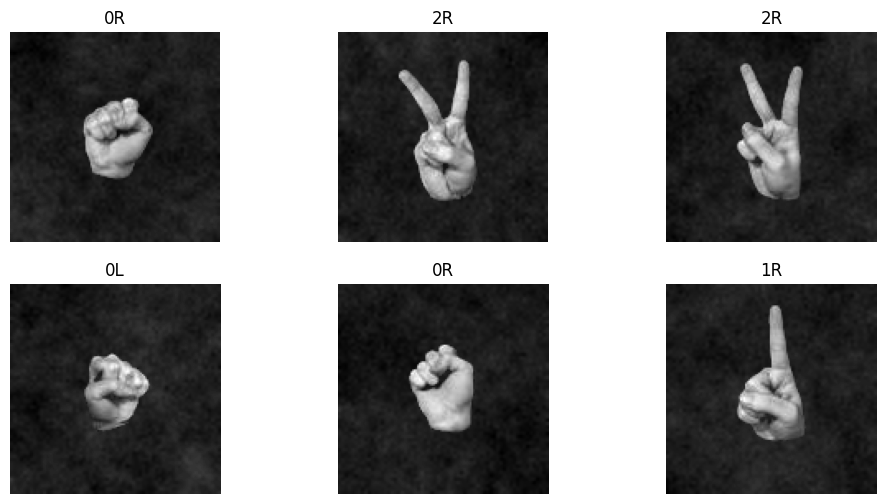

In [9]:
# explore if we tagged them accordingly and sorted correctly
n_rows, n_cols = 2, 3
total = n_rows*n_cols
samples = np.random.choice(train_df.index, total)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12,6))

for rcindex in range(total):
    sample = samples[rcindex]
    title = raw_data_train[2][sample]
    img =  Image.open(os.path.join(TRAIN_PATH, raw_data_train[0][sample]))
    plt.subplot(n_rows, n_cols, rcindex+1)
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

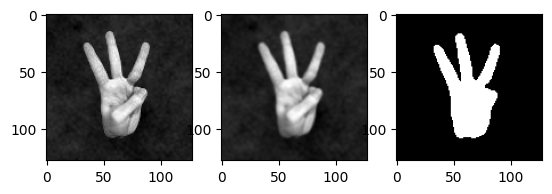

In [10]:
# Transform to be applied before train or predict in the CNN

# random choice
samples = np.random.choice(train_df.index, total)
sample = samples[0]
img =  Image.open(os.path.join(TRAIN_PATH, raw_data_train[0][sample]))

def preprocess_img(img, kSize=(3,3), iterations=2, display=False):
    # img = 255*img
    img = np.asarray(img)
    # apply simple transformations
    blur = cv2.GaussianBlur(img.copy(),kSize,0)
    thresholded = cv2.threshold(blur, 80, 255, cv2.THRESH_BINARY)[1]
    thresholded = thresholded.astype(np.uint8).copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, kSize)
    dilated = cv2.dilate(thresholded, kernel=kSize, iterations=iterations)
    eroded = cv2.erode(dilated, kernel=kSize, iterations=iterations)

    # apply mask and display original_masked and mask
    img_masked = eroded.astype(np.uint8)
    img_masked = Image.fromarray(img_masked)
    #img_masked = (img/255*eroded).astype(int)
    #img_masked = Image.fromarray(img_masked)
    if display:
        plt.subplot(1,3,1)
        plt.imshow(img, cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(blur, cmap='gray');            
        plt.subplot(1,3,3)
        plt.imshow(img_masked, cmap='gray')
    return img_masked

_ = preprocess_img(img, iterations=2, display=True)

In [11]:
# check for some metrics to see the dataset distribution 
def get_metrics(dataset, path=TRAIN_PATH):
    metrics = dict()
    for name in dataset.fname:
        img = Image.open(os.path.join(path, name))
        img = preprocess_img(img)
        metrics['mean'], metrics['std'] = np.asarray(img).mean(), np.asarray(img).std()
    return np.mean(metrics['mean']), np.mean(metrics['std'])

get_metrics(train_df, path=TRAIN_PATH) # training set mean and std dev

(45.80474853515625, 97.8883848477231)

In [19]:
get_metrics(val_df, path=TRAIN_PATH) # validation set mean and std dev

(42.13165283203125, 94.70213990089749)

In [12]:
get_metrics(test_df, path=TEST_PATH) # test set mean and std dev

(45.19775390625, 97.37859255464629)

In [18]:
train_df.shape, val_df.shape, test_df.shape # train, valid and test sets counts

((14400, 5), (3600, 5), (3600, 5))

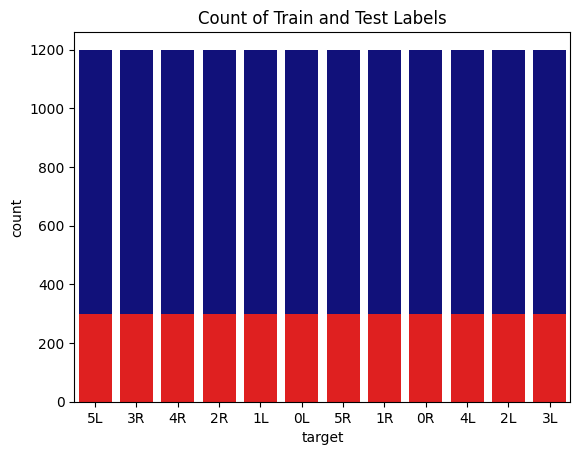

In [23]:
# label distribution
g = sns.countplot(x=train_df.label, color='darkblue')
g = sns.countplot(x=val_df.label, color='green', ax=g)
g = sns.countplot(x=test_df.label, color='red', ax=g)
g.set_xlabel('target')
g.set_title('Count of Train and Test Labels')
plt.show()

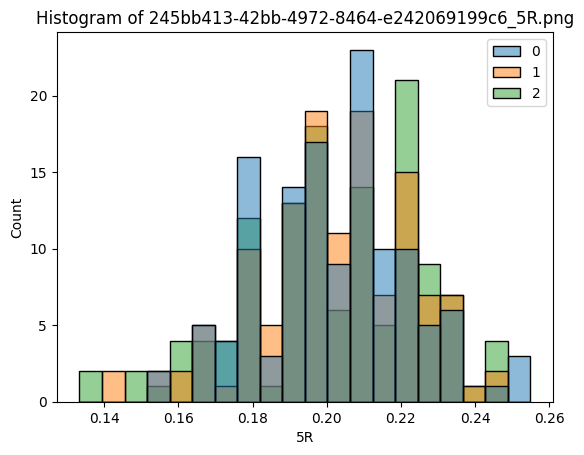

In [24]:
# Histogram distribution of one sample
sample = np.random.choice(train_df.index)
sample_name = raw_data_train[0][sample]
sample_label = raw_data_train[-1][sample]

sample_img = mpimg.imread(os.path.join(TRAIN_PATH, raw_data_train[0][sample]))
g = sns.histplot(sample_img[:, [2, 1, 0]], bins=20)#, hist=True, kde=True, color=None, axlabel=None, label=None, ax=None, x=None)
g.set_xlabel(sample_label)
g.set_title('Histogram of ' + sample_name)
plt.show()

In [25]:
# export data to csv
train_df.to_csv('info_train.csv', index=False, sep=',', encoding='utf-8')
val_df.to_csv('info_val.csv', index=False, sep=',', encoding='utf-8')
test_df.to_csv('info_test.csv', index=False, sep=',', encoding='utf-8')

In [29]:
# make the folders
def make_folders(in_, df_):

    for folder in df_.label.unique():
        new_folder = os.path.join(in_, folder)
        if not os.path.exists(new_folder):
            os.makedirs(new_folder, exist_ok=True)
        
make_folders(in_='fingers_sorted/train', df_=train_df)
make_folders(in_='fingers_sorted/valid', df_=val_df)
make_folders(in_='fingers_sorted/test', df_=test_df)

In [32]:
# copy folders to the destination
def copy_to_folders(src_folder_, dst_folder_, df_):
    for label in df_.label.unique():
        names = df_.fname[df_.label==label]
        [shutil.copyfile(os.path.join(src_folder_, name), os.path.join(dst_folder_, label, name)) for name in names]
        
copy_to_folders(src_folder_='fingers/train', dst_folder_='fingers_sorted/train', df_=train_df)
copy_to_folders(src_folder_='fingers/train', dst_folder_='fingers_sorted/valid', df_=val_df)
copy_to_folders(src_folder_='fingers/test', dst_folder_='fingers_sorted/test', df_=test_df)